# Novas funções de teste

In [27]:
import pyomo as pyo

# Número de meses
T = 36

# Parâmetros
a = 60  # Constante da demanda
b = 1/2000    # Elasticidade da demanda
variable_cost_percentage = 0.25  # Percentual de custos variáveis - Depois será utilizado no problema de otimização estocástica
variable_expenses_percentage = 0.1  # Percentual de custos variáveis
taxes_percentage = 0.1  # Percentual de impostos sobre vendas, neste caso consideramos uma empresa que opera em lucro presumido
CF = 10000    # Custo fixo mensal
DF = 10000    # Despesa fixa mensal
theta_AR = 1
theta_I = 1
theta_AP = 1

# Intervalos de preço e quantidade
P_min = 50
P_max = 50
Q_min = 3000
Q_max = 10000

# Variação inicial da NCG (exemplo)
initial_NCG = 50 * 10000 - 247500
initial_inventory = 50000

# Instanciação das Variáveis e Parâmetros

In [28]:
from pyomo.environ import *

# Cria um modelo concreto
naive_model = model = ConcreteModel()

# Períodos
T = 36

# Variáveis de decisão
model.P = Var(range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos

initialize_variable_costs=[variable_cost_percentage*1.015**t for t in range(1, T+1)]

model.variable_cost_percentage = Param(range(1, T+1), initialize=lambda model, t: initialize_variable_costs[t-1], mutable=True)
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, t):
    return model.P[t] * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, t):
    # return 0
    return revenue_rule(model, t) * model.theta_AR

def I_rule(model, t):
    # return 0
    return (model.variable_cost_percentage[t] * revenue_rule(model, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, t):
    i_t_minus_1 = I_rule(model, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, t) + model.variable_expenses_percentage * revenue_rule(model, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return (revenue_rule(model, t_final) -\
        model.variable_cost_percentage[t_final] * revenue_rule(model, t_final) - \
        model.variable_expenses_percentage * revenue_rule(model, t_final) - \
        model.taxes_percentage * revenue_rule(model, t_final) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, t_final))

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, t):
    return (revenue_rule(model, t) -\
        model.variable_cost_percentage[t] * revenue_rule(model, t) - \
        model.variable_expenses_percentage * revenue_rule(model, t) - \
        model.taxes_percentage * revenue_rule(model, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, t)) >= 0

model.fco = Constraint(range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, t):
    return model.Q[t] <= model.Q[t-1] * 1.1 if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, t) <= 10e10
    
    return (revenue_rule(model, t) -\
        model.variable_cost_percentage[t] * revenue_rule(model, t) - \
        model.variable_expenses_percentage * revenue_rule(model, t) - \
        model.taxes_percentage * revenue_rule(model, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, t-1) -\
        model.variable_cost_percentage[t-1] * revenue_rule(model, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, t-1) - \
        model.taxes_percentage * revenue_rule(model, t-1) - \
        model.fix_costs - model.fix_expenses) * 0.95)

model.profit = Constraint(range(1, T+1), rule=profit_rule)

# Componentes da NCG
model.AR = Expression(range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
for t in range(1, T+1):
    print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpe19zcc7_.pyomo.lp
Reading time = 0.00 seconds
x1: 38 rows, 72 columns, 71 nonzeros
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 38 rows, 72 columns and 71 nonzeros
Model fingerprint: 0x1b1f1767
Model has 3 quadratic objective terms
Model has 70 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [3e-01, 1e+00]
  QLMatrix range   [8e+02, 2e+03]
  Objective range  [2e+04, 2e+04]
  QObjective range [8e-01, 1e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [3e+03, 1e+11]
  QRHS range       [1e+03, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to av

In [29]:
# Verificar se o modelo foi solucionado com sucesso
if result.solver.termination_condition == TerminationCondition.optimal:
    for t in range(1, T+1):
        # Calcula e exibe as componentes diretamente sem usar as expressões model.AR, model.I, model.AP, model.NCG
        AR_value = AR_rule(model, t)()
        I_value = I_rule(model, t)()
        AP_value = AP_rule(model, t)()
        NCG_value = NCG_rule(model, t)()
        revenue_value = revenue_rule(model, t)()

        print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
        print(f'  AR = {AR_value}, Estoque (I) = {I_value}, AP = {AP_value}, NCG = {NCG_value}')
        print(f'  NCG = AR - I - AP = {AR_value} - {I_value} - {AP_value} = {NCG_value}')
        # agora o lucro
        # print(f'  Lucro = {revenue_value - model.variable_cost_percentage * revenue_value - model.variable_expenses_percentage * revenue_value - model.taxes_percentage * revenue_value - model.fix_costs - model.fix_expenses}')
else:
    print("O modelo não encontrou uma solução ótima.")

Mês 1: Preço = 50.0, Quantidade = 3000
  AR = 150000.0, Estoque (I) = 38062.49999999999, AP = 3062.4999999999927, NCG = -67500.0
  NCG = AR - I - AP = 150000.0 - 38062.49999999999 - 3062.4999999999927 = -67500.0
Mês 2: Preço = 50.0, Quantidade = 3278.637842888904
  AR = 163931.89214444518, Estoque (I) = 42221.68339612775, AP = 20552.372610572278, NCG = 601.202930000658
  NCG = AR - I - AP = 163931.89214444518 - 42221.68339612775 - 20552.372610572278 = 601.202930000658
Mês 3: Preço = 50.0, Quantidade = 3598.565131019518
  AR = 179928.2565509759, Estoque (I) = 47036.771731701876, AP = 22807.913990671714, NCG = 18555.911362005394
  NCG = AR - I - AP = 179928.2565509759 - 47036.771731701876 - 22807.913990671714 = 18555.911362005394
Mês 4: Preço = 50.0, Quantidade = 3936.7699348292026
  AR = 196838.49674146014, Estoque (I) = 52229.30145030089, AP = 24876.379392745028, NCG = 20034.304507009936
  NCG = AR - I - AP = 196838.49674146014 - 52229.30145030089 - 24876.379392745028 = 20034.304507009

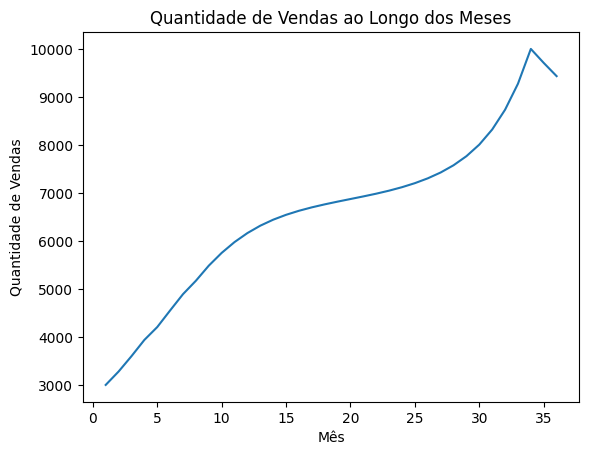

In [30]:
# Plotando gráfico de quantidade de vendas
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

# Descobrindo possíveis variações no valor de custos variáveis com base na variação do dólar

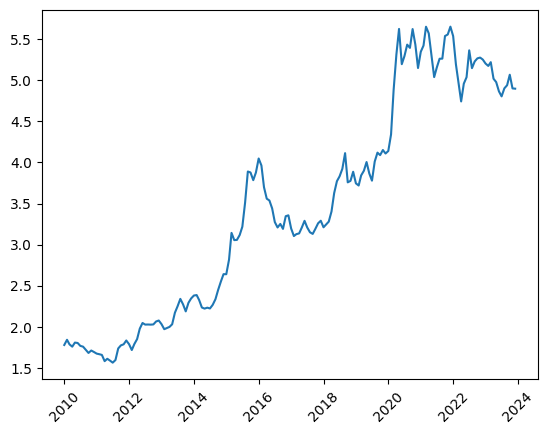

In [31]:
from currency_converter import CurrencyConverter
from datetime import datetime
from numpy import mean
import calendar
import matplotlib.pyplot as plt

c = CurrencyConverter(fallback_on_missing_rate=True)

# Pega a média do dólar mensal desde 2010
dolar_mean = []
for i in range(2010, 2024):
    for j in range(1, 13):
        _, num_days = calendar.monthrange(i, j)
        dolar_mean.append(mean([c.convert(1, 'USD', 'BRL', date=datetime(i, j, k)) for k in range(1, num_days+1)]))

# Plota o gráfico utilizando datas no eixo x
plt.plot([datetime(i, j, 1) for i in range(2010, 2024) for j in range(1, 13)], dolar_mean)
plt.xticks(rotation=45)
plt.show()


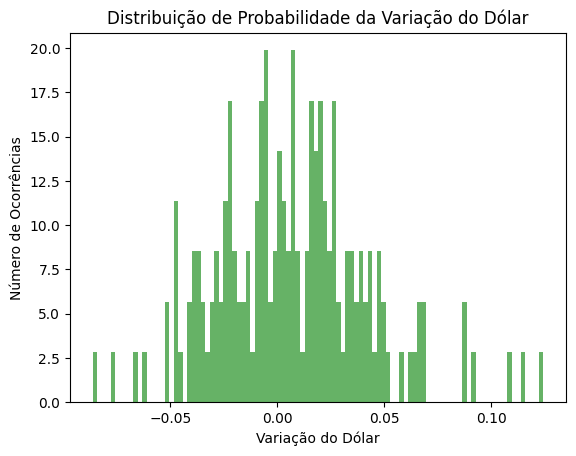

In [32]:
# Distribuição de probabilidades da variação do dólar baseado na série temporal dolar_mean
from scipy.stats import norm
import numpy as np

dolar_mean_variation = np.diff(dolar_mean)

#  Agora uma lista que pega o calor do dolar e soma com a variação
dolar_mean_variation = [(dolar_mean[i] + dolar_mean_variation[i])/dolar_mean[i] - 1 for i in range(len(dolar_mean_variation))]

# plot the histogram
plt.hist(dolar_mean_variation, bins=100, density=True, alpha=0.6, color='g')
plt.xlabel('Variação do Dólar')
plt.ylabel('Número de Ocorrências')
plt.title('Distribuição de Probabilidade da Variação do Dólar')
plt.show()


In [33]:
# Extrair os parâmetros dos dados
target_mean = np.mean(dolar_mean_variation)
target_variance = np.var(dolar_mean_variation)
target_skewness = np.mean((dolar_mean_variation - target_mean)**3) / target_variance**(3/2)
target_kurtosis = np.mean((dolar_mean_variation - target_mean)**4) / target_variance**2


In [34]:
import statsmodels.sandbox.distributions.extras as extras
import scipy.interpolate as interpolate
import scipy.stats as ss
import matplotlib.pyplot as plt  
import numpy as np

def generate_normal_four_moments(mu, sigma, skew, kurt, size=10000, sd_wide=10):
   f = extras.pdf_mvsk([mu, sigma, skew, kurt])
   x = np.linspace(mu - sd_wide * sigma, mu + sd_wide * sigma, num=500)
   y = [f(i) for i in x]
   yy = np.cumsum(y) / np.sum(y)
   inv_cdf = interpolate.interp1d(yy, x, fill_value="extrapolate")
   rr = np.random.rand(size)

   return inv_cdf(rr)

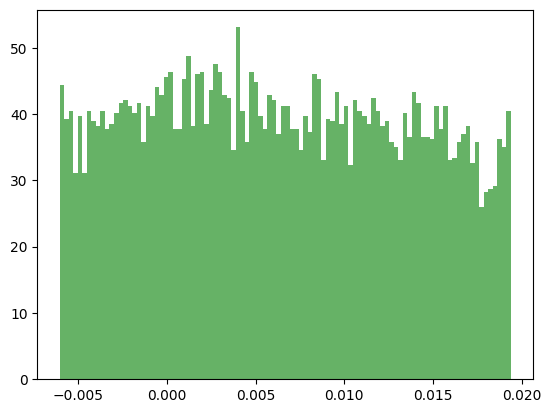

In [35]:
data = generate_normal_four_moments(mu=target_mean, sigma=target_variance, skew=target_skewness, kurt=target_kurtosis)

# plot the histogram
plt.hist(data, bins=100, density=True, alpha=0.6, color='g')

# Criando para 5 cenários
scenarios = 50
scenarios_data = []

initial_variable_costs = 0.25
dolar_affect_parameter = 1
for i in range(scenarios):
    scenario_data = []
    for j in range(1, T+1):
        if j == 1:
            scenario_data.append(initial_variable_costs)
            continue

        data = generate_normal_four_moments(mu=target_mean, sigma=target_variance, skew=target_skewness, kurt=target_kurtosis, size=1)[0]
        data = scenario_data[-1] + data * dolar_affect_parameter
        scenario_data.append(data)
    
    scenarios_data.append(scenario_data)

# Mostrando a Relevância do Dólar para a Empresa

In [36]:
from pyomo.environ import *

# Cria um modelo concreto
model = ConcreteModel()

# Períodos
T = 36

# Variáveis de decisão, agora são T * scenarios
model.P = Var(range(1, scenarios+1), range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, scenarios+1), range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1])

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
for i in range(1, scenarios+1):
    model.Q[i, 1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P[i, t] * model.Q[i, t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_expenses_percentage * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG


# Função objetivo
def objective_rule(model):
    i = 1
    return sum(revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t) for t in range(1, T+1))

def objective_rule(model):
    t_final = T
    return sum(revenue_rule(model, i, t_final) -\
        model.variable_cost_percentage[i, t_final] * revenue_rule(model, i, t_final) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_final) - \
        model.taxes_percentage * revenue_rule(model, i, t_final) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_final) for i in range(1, scenarios+1))/scenarios

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[i, t] <= model.Q[i, t-1] * 1.1 if t > 1 else model.Q[i, t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * 0.95)

model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

# Componentes da NCG
# model.AR = Expression(range(1, T+1), rule=AR_rule)
# model.I = Expression(range(1, T+1), rule=I_rule)
# model.AP = Expression(range(1, T+1), rule=AP_rule)
# model.NCG = Expression(range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpzpvrpodt.pyomo.lp
Reading time = 0.02 seconds
x1: 1900 rows, 3551 columns, 3550 nonzeros
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1900 rows, 3551 columns and 3550 nonzeros
Model fingerprint: 0x7e3a32f7
Model has 150 quadratic objective terms
Model has 3500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [2e-01, 1e+00]
  QLMatrix range   [8e+02, 2e+03]
  Objective range  [2e+04, 2e+04]
  QObjective range [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [3e+03, 1e+11]
  QRHS range       [1e+03, 1e+11]
         Consider reformulating model or setting NumericFocus paramete

Text(0.5, 1.0, 'Quantidade de Vendas ao Longo dos Meses Para Cada Cenário')

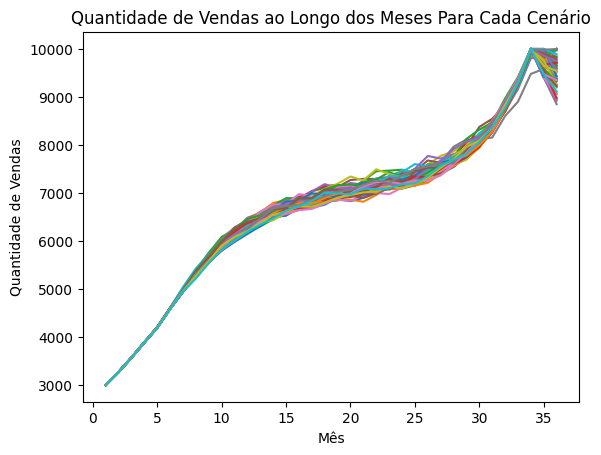

In [37]:
# plot de preço e quantidade para cada cenário
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [model.Q[i, t].value for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses Para Cada Cenário')

In [38]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T = 36

# Variáveis de decisão, agora são T * scenarios
model.P = Var(range(1, scenarios+1), range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P[i, t] * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_expenses_percentage * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(revenue_rule(model, i, t_final) -\
        model.variable_cost_percentage[i, t_final] * revenue_rule(model, i, t_final) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_final) - \
        model.taxes_percentage * revenue_rule(model, i, t_final) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_final) for i in range(1, scenarios+1))/scenarios

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * 1.1 if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * 0.95)

model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

# Componentes da NCG
# model.AR = Expression(range(1, T+1), rule=AR_rule)
# model.I = Expression(range(1, T+1), rule=I_rule)
# model.AP = Expression(range(1, T+1), rule=AP_rule)
# model.NCG = Expression(range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpwrxf3i15.pyomo.lp
Reading time = 0.01 seconds
x1: 1900 rows, 1836 columns, 3550 nonzeros
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1900 rows, 1836 columns and 3550 nonzeros
Model fingerprint: 0xc71a8385
Model has 150 quadratic objective terms
Model has 3500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [2e-01, 1e+00]
  QLMatrix range   [8e+02, 2e+03]
  Objective range  [2e+04, 2e+04]
  QObjective range [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [3e+03, 1e+11]
  QRHS range       [1e+03, 1e+11]
         Consider reformulating model or setting NumericFocus paramete

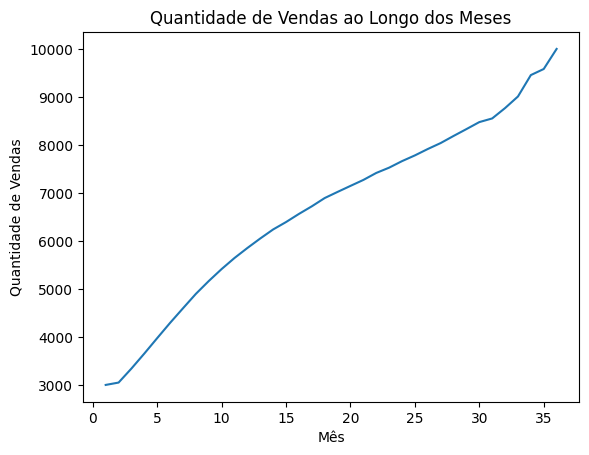

In [39]:
# Plotando gráfico de quantidade de vendas
plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

In [40]:
from pyomo.environ import SolverFactory

# Função para calcular o valor esperado de um modelo "Wait-and-See"
def calcular_valor_esperado(modelo, cenarios):
    solver = SolverFactory('gurobi')
    valor_esperado = 0
    
    for cenario in cenarios:
        print(f"Calculando o valor esperado para o cenário {cenario}")
        for t in range(1, T + 1):
            modelo.variable_cost_percentage[t] = cenario[t-1]

        resultado = solver.solve(modelo, tee=False)
        valor_esperado += modelo.objective()
    
    return valor_esperado/len(cenarios)

# Cálculo do valor estocástico
solver = SolverFactory('gurobi')
resultado_stochastic = solver.solve(stochastic_model, tee=True)
z = stochastic_model.objective()
# z = resultado_stochastic.Solution.Objective['value']

# Definir os cenários (substitua pelos seus cenários reais)

cenarios = [[scenarios_data[i][j] for j in range(T)] for i in range(scenarios)]

# Para o naive_model, fixar todos os Q e P
# for t in range(1, T+1):
#     naive_model.Q[t].fix(naive_model.Q[t].value)

# Cálculo do valor "Wait-and-See" para cada cenário
z_ws = calcular_valor_esperado(naive_model, cenarios)

# Cálculo do EVPI
evpi = z - z_ws

print(f"Valor Estocástico (z): {z}")
print(f"Valor Wait-and-See (z_ws): {z_ws}")
print(f"Expected Value of Perfect Information (EVPI): {evpi}")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmp__k9okvf.pyomo.lp
Reading time = 0.02 seconds
x1: 1900 rows, 1836 columns, 3550 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1900 rows, 1836 columns and 3550 nonzeros
Model fingerprint: 0xc71a8385
Model has 150 quadratic objective terms
Model has 3500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [2e-01, 1e+00]
  QLMatrix range   [8e+02, 2e+03]
  Objective range  [2e+04, 2e+04]
  QObjective range [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [3e+03, 1e+11]
  QRHS range       [1e+03, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issue

In [41]:
from pyomo.environ import SolverFactory

# Função para calcular o valor esperado de um modelo "Wait-and-See"
def calcular_valor_esperado(modelo, cenarios):
    solver = SolverFactory('gurobi')
    valor_esperado = 0
    
    for cenario in cenarios:
        for t in range(1, T + 1):
            modelo.variable_cost_percentage[t] = cenario[t-1]

        resultado = solver.solve(modelo, tee=False)
        valor_esperado += modelo.objective()

        print("O objetivo atual é: ", modelo.objective())
    
    return valor_esperado/len(cenarios)

# Cálculo do valor estocástico
solver = SolverFactory('gurobi')
resultado_stochastic = solver.solve(stochastic_model, tee=False)
z = stochastic_model.objective()
# z = resultado_stochastic.Solution.Objective['value']

# Definir os cenários (substitua pelos seus cenários reais)

cenarios = [[scenarios_data[i][j] for j in range(T)] for i in range(scenarios)]

# Para o naive_model, fixar todos os Q e P
for t in range(1, T+1):
    naive_model.Q[t].fix(naive_model.Q[t].value)

# Cálculo do valor "Wait-and-See" para cada cenário
z_ws = calcular_valor_esperado(naive_model, cenarios)

# Cálculo do EVPI
evpi = z - z_ws

print(f"Valor Estocástico (z): {z}")
print(f"Valor Wait-and-See (z_ws): {z_ws}")
print(f"VSS: {z - z_ws}")


model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was proven to be infeasible.
O objetivo atual é:  183333.52517599886
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was proven to be infeasible.
O objetivo atual é:  144077.85763514694
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was proven to be infeasible.
O objetivo atual é:  159499.45571737242
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was proven to be infeasible.
O objetivo atual é:  164459.8070872064
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was proven to be infeasible.
O objetivo atual é:  136158.5125518862
O objetivo atual é:  168755.1078572999
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was proven to be infeasible.
O objetivo atual é:

# Testes de EVPI